# Auto Labelling (Demo)
This Jupyter notebook presents an example that allows users to label movie categories (original example).

In [1]:
import pandas as pd
import numpy as np

from src.toolkit.plot import *
from src.toolkit.autolabel import *

from sklearn.naive_bayes import MultinomialNB

## Data Input
* CSV file containing text data in the first column
    * A subset of [Full MovieLens Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset/home) is used for demonstration purposes.
* Dictionary containing labels for each category.

In [2]:
texts_path = "data/movies500.csv"
labels_path = "data/labels.csv"
enriched_labels_path = "data/enriched_labels.csv"
labelled_path = "data/movies500_labelled.csv"
stopwords_path = "data/stopwords.csv"

movies = pd.read_csv(texts_path)
labels = pd.read_csv(labels_path)

In [3]:
movies.head()

,overview,Action,Romance,Science Fiction,Thriller,War,Western
0,A family wedding reignites the ancient feud be...,0,1,0,0,0,0
1,"Cheated on, mistreated and stepped on, the wom...",0,1,0,0,0,0
2,"Obsessive master thief, Neil McCauley leads a ...",1,0,0,1,0,0
3,An ugly duckling having undergone a remarkable...,0,1,0,0,0,0
4,"A mischievous young boy, Tom Sawyer, witnesses...",1,0,0,0,0,0


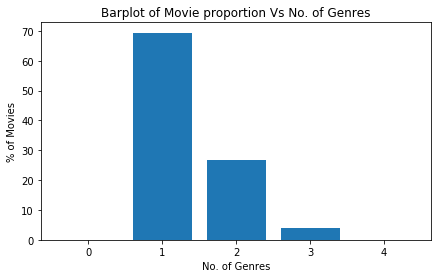

In [4]:
moviesGenre = movies.iloc[:, 1:]
numGenres = list(range(5))
labelCount = [round((moviesGenre.sum(axis=1)==i).mean(),3)*100 for i in range(5)]

barplot(numGenres, 
        labelCount, 
        figsize=(7,4), 
        title='Barplot of Movie proportion Vs No. of Genres',
        x_label='No. of Genres',
        y_label='% of Movies')

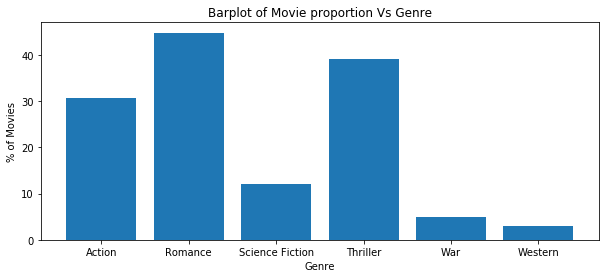

In [5]:
genreTitle = moviesGenre.columns
movieCount = (round(moviesGenre.mean(axis=0),3)*100).tolist()

barplot(genreTitle, 
        movieCount, 
        figsize=(10, 4), 
        title='Barplot of Movie proportion Vs Genre',
        x_label='Genre',
        y_label='% of Movies')

## Data Preprocessing

* Prepare text. Some operations are removng special characters, digits and stopwords etc. 
* Join bigrams that appear frequently into one word.

In [7]:
corpus = movies['overview']

# Text Preprocessing
preprocessed_corpus = corpus_preprocess(corpus=corpus, stopwords_path=stopwords_path)

# Replace bigrams    
movies['overview'] = corpus_replace_bigrams(min_df=50, max_df=500, corpus=preprocessed_corpus)

## Model Training
* Identifies key labels and enriches dictionary
* **Note** What happens here is due to the skewed training set where there are limited SF etc.

In [8]:
labels.head(10)

,Action,Romance,Science Fiction,Thriller,War,Western
0,terrorist,college,science,murder,ii,criminal
1,drug,girlfriend,NaN,criminal,war,NaN
2,operation,french,NaN,crime,NaN,NaN
3,cia,romantic,NaN,detective,NaN,NaN
4,undercover,marry,NaN,killer,NaN,NaN


In [9]:
autoLabeller = AutoLabeller(labels, corpus, movies)
enriched_labels = autoLabeller.train(n_words=20)

enriched_labels.to_csv(enriched_labels_path)
enriched_labels.head(10)

,Action,Romance,Science Fiction,Thriller,War,Western
0,illegal,world,world,dealer,world,assignment
1,assignment,track,assign,track,murder,terrorist
2,district,best,murder,murder,singer,evidence
3,terrorist,challenge,assault,undercover,bodyguard,best
4,undercover,room,washington,drug,best,room
5,drug,french,terrorist,miami,room,japanese
6,consequence,farm,havoc,danger,french,guard
7,room,havoc,reluctant,consequence,farm,operation
8,japanese,professional,killer,file,paris,throw
9,file,compete,reason,operation,chase,current


## Model Application
* Utilises enriched labels
* Trains and applies multinomial naive bayes on input dataset
* **Can take some time to run**

In [10]:
mnb = MultinomialNB()
ypred = autoLabeller.apply(mnb)

## Output Data
* Csv file containing labels for each row

In [12]:
output = movies[["overview"]].join(ypred)
output.to_csv(labelled_path)
output.head(5)

,overview,Action,Romance,Science Fiction,Thriller,War,Western
0,family wedding reignite ancient feud nextdoor ...,0.0,1.0,0.0,1.0,1.0,0.0
1,cheat mistreat step woman hold breath wait elu...,0.0,0.0,0.0,0.0,1.0,0.0
2,obsessive master thief lead topnotch crew vari...,0.0,1.0,1.0,1.0,0.0,0.0
3,duckling undergone remarkable change harbor fe...,1.0,0.0,0.0,0.0,1.0,0.0
4,mischievous young boy witness murder becomes f...,0.0,0.0,1.0,0.0,0.0,0.0
